In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

In [2]:
from SafeBayes import SafeBayesLinearRegression

In [4]:

#Correct vs wrong model data generation

def generate_correct_model(n , sigma_sq = 1/40, pmax = 50):
    sigma = np.sqrt(sigma_sq)
    X = np.random.randn(n, pmax)
    X = np.hstack([np.ones((n, 1)), X]) # add intercept
    eps = sigma * np.random.randn(n)

    beta = np.hstack([ [0], np.ones(4)/10, np.zeros(pmax - 4)]) #as described in the paper: true beta is (0,0.1,...,0.1,0,...,0)

    y = X@beta + eps

    return X, y, beta


def generate_wrong_model(n , sigma_sq = 1/20, pmax = 50):
    coin_flip = (np.random.rand(n) > 0.5).astype(bool) #choose "relevant" indexes
    sigma = np.sqrt(sigma_sq)


    X = np.zeros((n, pmax))
    X[coin_flip, :] = np.random.randn(n, pmax)[coin_flip, :] #only for the relevant indexes, we draw from N(0,1)

    X = np.hstack([np.ones((n, 1)), X]) # add intercept

    eps = sigma*np.random.randn(coin_flip.sum()) #only for the relevant indexes

    beta = np.hstack([ [0], np.ones(4)/10 , np.zeros(pmax - 4)]) #as described in the paper: true beta is (0,0.1,...,0.1,0,...,0)

    #draw y
    y = np.zeros(n)
    y[coin_flip] = X[coin_flip]@beta + eps #correct model for the relevant indexes, 0 otherwise

    return X, y, beta


X,y, beta = generate_wrong_model(1000, pmax = 50)
R2 = 1 - (np.sum((y - X @ beta)**2) / np.sum((y - np.mean(y))**2))
print("R2 : ", R2)

R2 :  0.3901311424592373


## Useful functions

In [ ]:
from scipy.special import psi, softmax #Digamma function useful for RLogLoss
from scipy.stats import invgamma

#Functions to calculate the generalized posterior distributions
#See sec 2.5 of the paper/ sec 3.1 of the longer paper

#------------BETA----------------#
#Covariance matrix of the multivariate normal **posterior** for beta
# Remark : covariance matrix is in fact sigma_sq * Sigman_eta
def Sigman_eta(Sigma, Xn, eta):
  return np.linalg.inv(np.linalg.inv(Sigma) + eta * np.transpose(Xn) @ Xn)
#Expectation of the multivariate normal **posterior** for beta
def betan_eta(Sigma, Xn, eta, beta0, yn):
  return Sigman_eta(Sigma, Xn, eta) @ (np.linalg.inv(Sigma) @ beta0 + eta * np.transpose(Xn) @ yn)


#================================#

#------------SIGMA_SQ----------------#
#Parameters of the Inv-Gamma **posterior** for sigma_sq
def an_eta(a0, eta, n):
  return a0 + (eta * n)/2
def bn_eta(b0, eta, beta, Sigma, Xn, yn):
  betan = betan_eta(Sigma, Xn, eta, beta, yn)
  # sigman = Sigman_eta(sigma, Xn, eta)
  # return b0 + 1/2 * beta.T @ np.linalg.inv(sigma) @ beta + eta/2 * yn.T @ yn -1/2 * betan.T @ np.linalg.inv(sigman) @ betan
  return b0 + (eta / 2) * np.sum(np.square(yn - (Xn @ betan)))
#The induced expectation
def sigman_eta2(a,b):
  return b/(a-1)
#================================#


#=============TEST=============#

#Correct model

n = 10000
eta = 1 #On teste avec la posterior classique
pmax = 50
p = pmax #we set the max model as discussed in sec 5.4
X,y, beta_true = generate_correct_model(n, pmax = pmax)
print("Shape X : ", X.shape, " Shape y : ", y.shape)

#----------PRIOR PARAMETERS-----------#
#Sec 5 page 18
a_0 = 1
b_0 = 1/40
#Sigma_0 = sigma_sq_prior_sample * np.eye(p + 1)
Sigma_0 = np.eye(p + 1)
beta_0 = np.zeros(p + 1)
#-------------------------------------#

beta_n_eta = betan_eta(Sigma_0, X, eta, beta_0, y)
print("Beta_n_eta : ", np.round(beta_n_eta, 2))

a_n_eta = an_eta(a_0, eta, n)
b_n_eta = bn_eta(b_0, eta, beta_0, Sigma_0, X, y)
print("a_n_eta : ", a_n_eta, " b_n_eta : ", b_n_eta)

post_sigma_sq_mean = sigman_eta2(a_n_eta, b_n_eta)
print("Inverse Posterior sigma square mean (target = 40): ", 1/post_sigma_sq_mean)

Shape X :  (10000, 51)  Shape y :  (10000,)
Beta_n_eta :  [ 0.   0.1  0.1  0.1  0.1  0.  -0.  -0.   0.   0.  -0.   0.  -0.   0.
  0.  -0.  -0.   0.  -0.   0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  0.   0.  -0.  -0.   0.   0.   0.   0.  -0.   0.  -0.   0.  -0.   0.
 -0.   0.  -0.  -0.  -0.  -0.   0.  -0.  -0. ]
a_n_eta :  5001.0  b_n_eta :  123.0721466265179
Inverse Posterior sigma square mean (target = 40):  40.62657666298207


In [ ]:
# Functions defined for varying sigma^2 section 4.2 (bigger paper)

def RLogLoss(Xi, yi, eta, i, beta0, a0, b0, Sigma_0):
  if i>=1:
    a = an_eta(a0,eta,i)
    b = bn_eta(b0, eta, beta0, Sigma_0, Xi[:-1], yi[:-1])
    beta = betan_eta(Sigma_0, Xi[:-1], eta, beta0, yi[:-1])
    Sigma = Sigman_eta(Sigma_0, Xi[:-1], eta)
  else:
    a = a0
    b = b0
    beta = beta0
    Sigma = Sigma_0
  return 1/2 * np.log(2 * np.pi * b) - 1/2* psi(a) + 1/2 * (yi[-1] - Xi[-1] @ beta)**2 / (b/a) + 1/2 * Xi[-1].T @ Sigma @ Xi[-1]


def ILogLoss(Xi, yi, eta, i, beta0, a0, b0, Sigma_0):
  if i>=1:
    a = an_eta(a0,eta,i)
    b = bn_eta(b0, eta, beta0, Sigma_0, Xi[:-1], yi[:-1])
    beta = betan_eta(Sigma_0, Xi[:-1], eta, beta0, yi[:-1])
    sigma2 = sigman_eta2(a,b)
  else:
    a = a0
    b = b0
    beta = beta0
    sigma2 = sigman_eta2(a,b)
  return 1/2 * np.log(2 * np.pi * sigma2) - psi(a) + 1/2 * (yi[-1] - Xi[-1] @ beta)**2 / (sigma2)



In [ ]:
loss  = RLogLoss(X,y, 0.5, 50, beta_0, a_0, b_0, Sigma_0)
print("RLogLoss : ", loss)

loss  = ILogLoss(X,y, 1, 50, beta_0, a_0, b_0, Sigma_0)
print("ILogLoss : ", loss)

RLogLoss :  0.6171773899303261
ILogLoss :  -2.6610027378444165


In [ ]:
def SafeBayes(X, y, step_size=1, k_max=16, loss = RLogLoss, pmax=50, sigma2=1/40):
  num = int(k_max/step_size)
  etas = np.linspace(0,k_max,num)
  S_etas = np.zeros(num)

  # Constants to get the algorithm going
  # Found section A.2 of the paper -> this is not the good experiment, look at section 5.4 (long article) where they say they use same constant as in 5.1
  beta0 = np.zeros(pmax+1)
  a0 = 1
  b0 = sigma2 * a0
  #Sigma_0 = 10e3 * np.eye(pmax+1)
  Sigma_0 = np.eye(pmax+1)

  for eta, k in zip(etas, range(num)):
    for i in range(1,len(X)):
      Xi = X[:(i+1)]
      yi = y[:(i+1)]
      S_etas[k] += loss(Xi, yi, 2**(-eta), i, beta0, a0, b0, Sigma_0)
  eta = etas[np.argmin(S_etas)]
  return 2**(-eta)


In [ ]:
eta_star = SafeBayes(X, y, step_size=1, k_max=16, loss = ILogLoss, pmax=50, sigma2=1/40)
print("eta_star : ", eta_star)

eta_star :  1.0


In [ ]:
eta_star = SafeBayes(X, y, step_size=1, k_max=16, loss = RLogLoss, pmax=50, sigma2=1/40)
print("eta_star : ", eta_star)

eta_star :  0.4774208019552083


In [ ]:
def square_risk(beta,X_test,y_test):
    return np.mean((y_test - X_test@beta)**2)

In [ ]:
def experiment(X, y,X_test,y_test, step_size=1, k_max=16, pmax=50, sigma2=1/40):
  num = int(k_max/step_size)
  N = len(X)
  etas = np.linspace(0,k_max,num)
  S_R_Log_etas = np.zeros((N-1,num))
  S_I_Log_etas = np.zeros((N-1,num))

  # Constants to get the algorithm going
  beta0 = np.zeros(pmax+1)
  a0 = 1
  b0 = sigma2 * a0
  Sigma_0 = np.eye(pmax+1)

  for eta, k in zip(etas, range(num)):
    for i in range(1,len(X)):
      Xi = X[:(i+1)]
      yi = y[:(i+1)]
      S_R_Log_etas[(i-1):,k] += RLogLoss(Xi, yi, 2**(-eta), i, beta0, a0, b0, Sigma_0)
      S_I_Log_etas[(i-1):,k] += ILogLoss(Xi, yi, 2**(-eta), i, beta0, a0, b0, Sigma_0)


  best_etas_R_Log = etas[np.argmin(S_R_Log_etas,axis=1)]
  best_etas_I_Log = etas[np.argmin(S_I_Log_etas,axis=1)]
  square_risks = np.empty((N-1, 3))
  for k in range(N-1):
    beta_bayes = betan_eta(Sigma_0, X[:k], 1, beta0, y[:k])
    beta_R_Log_safe_bayes = betan_eta(Sigma_0, X[:k], 2**(-best_etas_R_Log[k]), beta0, y[:k])
    beta_I_Log_safe_bayes = betan_eta(Sigma_0, X[:k], 2**(-best_etas_I_Log[k]), beta0, y[:k])
    square_risks[k] = [square_risk(beta_bayes,X_test,y_test),square_risk(beta_R_Log_safe_bayes,X_test,y_test),square_risk(beta_I_Log_safe_bayes,X_test,y_test)]

  return square_risks

In [ ]:
X_test,y_test, _ = generate_wrong_model(10000, pmax = 50)
number_run = 10
all_risk = []
for _ in tqdm(range(number_run)):
    X,y, beta = generate_wrong_model(400, pmax = 50)
    all_risk.append(experiment(X, y,X_test,y_test, step_size=1, k_max=16, pmax=50, sigma2=1/40))
all_risk = np.stack(all_risk)
average_over_run_square_risks = np.mean(all_risk,axis=2)
number_of_samples_used = np.arange(2,len(X)+1)

100%|██████████| 10/10 [02:47<00:00, 16.74s/it]


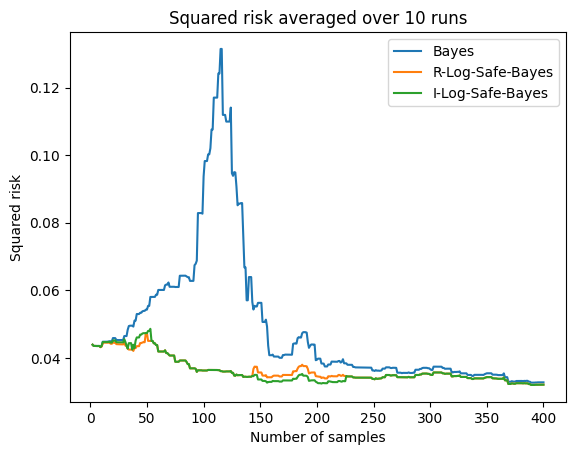

In [ ]:
plt.figure()
plt.plot(number_of_samples_used,all_risk[0],label = ["Bayes","R-Log-Safe-Bayes","I-Log-Safe-Bayes"])
plt.xlabel("Number of samples")
plt.ylabel("Squared risk")
plt.legend()
plt.title(f"Squared risk averaged over {number_run} runs")
plt.title
plt.show()

## Wrapper

In [9]:
#------------BETA----------------#
#Covariance matrix of the multivariate normal **posterior** for beta
# Remark : covariance matrix is in fact sigma_sq * Sigman_eta
def Sigman_eta(Xn, Sigma,eta):
  return np.linalg.inv(np.linalg.inv(Sigma) + eta * Xn.T @ Xn)

#Expectation of the multivariate normal **posterior** for beta

def betan_eta(Xn, yn, Sigma, eta, beta0):
  return Sigman_eta(Xn, Sigma, eta) @ (np.linalg.inv(Sigma) @ beta0 + eta * Xn.T @ yn)

#================================#

#------------SIGMA_SQ----------------#
#Parameters of the Inv-Gamma **posterior** for sigma_sq

def an_eta(a0, eta, n):
  return a0 + (eta * n)/2


def bn_eta(Xn, yn, b0, eta, mean_beta_posterior):
  return b0 + (eta / 2) * np.sum(np.square(yn - (Xn @ mean_beta_posterior)))

In [13]:
# Functions defined for varying sigma^2 section 4.2 (bigger paper)

def RLogLoss(Xi, yi, eta, i, beta0, a0, b0, Sigma_0):
  if i>=1:

    beta = betan_eta( Xi[:-1], yi[:-1], Sigma_0, eta, beta0)
    Sigma = Sigman_eta(Xi[:-1], Sigma_0, eta)
    a = an_eta(a0,eta,i)
    b = bn_eta(Xi[:-1], yi[:-1], b0, eta, beta)
  else:
    a = a0
    b = b0
    beta = beta0
    Sigma = Sigma_0
  return 1/2 * np.log(2 * np.pi * b) - 1/2* psi(a) + 1/2 * (yi[-1] - Xi[-1] @ beta)**2 / (b/a) + 1/2 * Xi[-1].T @ Sigma @ Xi[-1]

def ILogLoss(Xi, yi, eta, i, beta0, a0, b0, Sigma_0):
  if i>=1:

    beta = betan_eta( Xi[:-1], yi[:-1], Sigma_0, eta, beta0)
    a = an_eta(a0,eta,i)
    b = bn_eta(Xi[:-1], yi[:-1], b0, eta, beta)
    sigma2 = sigman_eta2(a,b)
  else:
    a = a0
    b = b0
    beta = beta0
    sigma2 = sigman_eta2(a,b)
  return 1/2 * np.log(2 * np.pi * sigma2) - psi(a) + 1/2 * (yi[-1] - Xi[-1] @ beta)**2 / (sigma2)

pmax = 50

In [14]:
def SafeBayes(X, y, step_size=1, k_max=16, loss = RLogLoss, pmax=50, sigma2=1/40, beta0 = np.zeros(pmax+1), a0 = 1, b0 = 1/40, Sigma_0 = np.eye(pmax+1)):
  num = int(k_max/step_size)
  etas = np.linspace(0,k_max,num)
  S_etas = np.zeros(num)

  for eta, k in zip(etas, range(num)):
    for i in range(1,len(X)):
      Xi = X[:(i+1)]
      yi = y[:(i+1)]
      S_etas[k] += loss(Xi, yi, 2**(-eta), i, beta0, a0, b0, Sigma_0)
  eta = etas[np.argmin(S_etas)]
  return 2**(-eta)


In [16]:
p = pmax
def GeneralizedPosteriors(X, y, eta, beta_0= np.zeros(pmax+1), Sigma_0= np.eye(p + 1), a0= 1, b0 = 1/40):

  """ For a given eta, return the generalized posteriors parameters for beta and sigma_sq
      Note that for eta = 1, this gives the "classic" posteriors

      Params:
      ----------
      X,y : data (numpy.arrays, shape (n x p+1), (n,1)
      eta : learning rate for generalized posterior

      beta_0, Sigma_0 : prior parameters for the beta prior multivariate normal distribution
        NOTE : actually, the distribution of beta depends on sigma_sq and the true variance is sigma_sq * Sigma_0

      a0, b0 : prior parameters for the inverse gamma distribution of sigma_sq


      Returns:
      ----------
      beta_params: tuple containing post. multi. normal mean and Sigma_n_eta (variance is once again sigma_sq * Sigma_n_eta)
      sigma_sq_params : tuple containing  posterior inverse-gamma dist. mean and parameters for sigma_sq
  """

  n= y.shape[0]

  ####----Compute Beta posterior params-------##
  Sigma_n_eta = Sigman_eta(X, Sigma_0, eta)
  mean_beta_posterior = betan_eta(X, y, Sigma_0, eta, beta_0)

  beta_params = (mean_beta_posterior, Sigma_n_eta)

  ####----Compute sigma_sq posterior-----#
  a_posterior = an_eta(a0, eta, n)
  b_posterior = bn_eta(X, y, b0, eta, mean_beta_posterior)
  mean_sigma_sq_posterior = b_posterior / (a_posterior - 1)

  sigma_sq_params = (mean_sigma_sq_posterior, a_posterior, b_posterior)

  return beta_params, sigma_sq_params


In [17]:
def SafeBayesLR(X,y, loss = "RLogLoss", beta_0 = np.zeros(pmax+1), Sigma_0 = np.eye(p + 1), a0 = 1, b0 = 1/40,  step_size=1, k_max=16, pmax=50, sigma2=1/40,  verbose = False):

  """ Wrapper for the full pipeline:
    1. Run Safe Bayes for finding optimal eta
    2. Return the Generalized posteriors for this optimal eta

    Verbose (bool) for displaying
  """


  n = y.shape[0]
  loss = RLogLoss if loss == "RLogLoss" else ILogLoss
  if verbose:
    print("Running Safe Bayes to find optimal eta...")

  start = time.time()
  eta = SafeBayes(X, y, step_size, k_max, loss, pmax, sigma2, beta_0, a0, b0, Sigma_0)
  end = time.time()
  if verbose:
    print("Found eta* = {} in {} s".format(round(eta, 2), round(end-start, 2)))



  if verbose:
    print("Computing generalized posteriors...")

  beta_params, sigma_sq_params = GeneralizedPosteriors(X, y, eta, beta_0, Sigma_0, a0, b0)

  if verbose:
    print("Done.")

  return beta_params, sigma_sq_params, eta




In [19]:
from scipy.special import psi, softmax #Digamma function useful for RLogLoss
X,y, beta = generate_correct_model(500, pmax = 50)
beta_params, sigma_sq_params, eta = SafeBayesLR(X, y, verbose = True)

Running Safe Bayes to find optimal eta...
Found eta* = 0.23 in 10.13 s
Computing generalized posteriors...
Done.


In [6]:
X,y, beta = generate_correct_model(500, pmax = 50)
SafeBayesLR = SafeBayesLinearRegression()
beta_params, sigma_sq_params, eta = SafeBayesLR.fit(X, y, verbose=True)

Running Safe Bayes to find optimal eta...
Found eta* = 0.23 in 16.45 s
Computing generalized posteriors...
Done.


In [7]:
1/sigma_sq_params[0]

46.047601890702566